# Capstone Project - The Battle of Neighborhoods

### Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , italian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great italian resturants.

### Data 
For this project we need the following data :
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> italian resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only italian resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are italian Resturants.
- Find rating , tips and like count for each italian Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
- What is best location in New York City for italian Cuisine ? 
- Which areas have potential italian Resturant Market ? 
- Which all areas lack italian Resturants ?
- Which is the best place to stay if I prefer italian Cuisine ?

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
!pip install geocoder

     |████████████████████████████████| 102kB 311kB/s ta 0:00:01


In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'OX13HQ3GH2D4BAACDFXPF2CCBAQVFT0T5BCS3IB20SLJXBY0' # your Foursquare ID
    CLIENT_SECRET ='SRV5VH1V04R4PKDWBF2WKPNK2WOTR2YOSL0AYEIV5KHYHWO5' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [8]:
# get new york data
new_york_data=get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

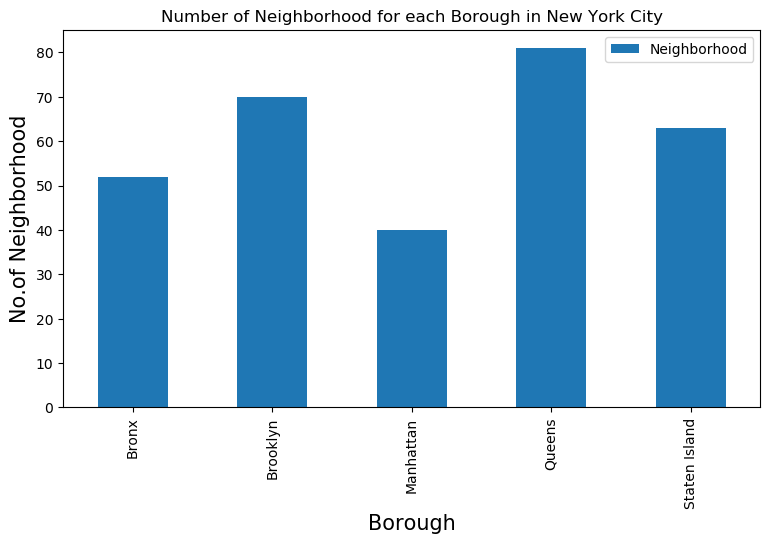

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect italian resturants for each Neighborhood

In [12]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(Italian_resturants)))
    for resturant_detail in Italian_resturants.values.tolist():
        id, name , category=resturant_detail
        Italian_rest_ny = Italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:1
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:2
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
( 10 / 306 ) Italian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Resturants in Baychester, Bronx:2
( 12 / 306 ) Italian Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Italian Resturants in City Island, Bronx:3
( 14 / 306 ) Italian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Italian Resturants in University Heights, Bronx:0
( 16 / 306 ) Italian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Resturants in Fordham, Bronx:8
( 18 / 306 ) Italian Resturants in East Tremont, Bronx:

Now that we have got all the italian resturants in new york city , we will analyze it

In [13]:
Italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's


In [14]:
Italian_rest_ny.shape

(543, 4)

We got 543 italian Resturants across New York City

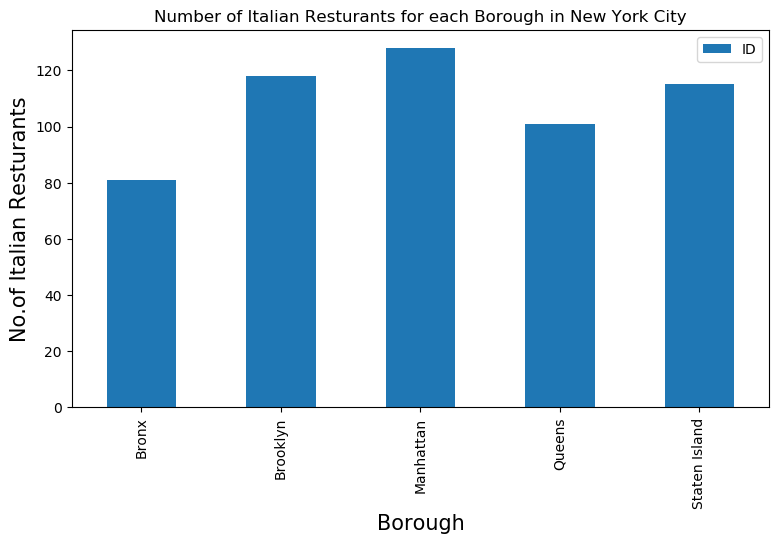

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
Italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of italian resturants

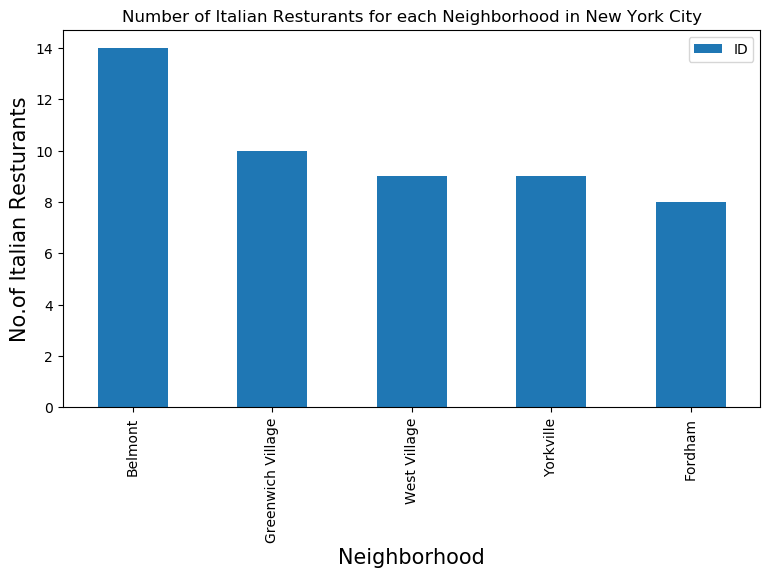

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
Italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
Italian_rest_ny[Italian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
341,Queens,Floral Park,4c450fae74ffc928328676cc,Luigi's Restaurant & Bar


So Floral Park in Queens has the highest number of italian Resturants with a total count of 9.

Now we will get the ranking of each resturant for further analysis.

In [20]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'OX13HQ3GH2D4BAACDFXPF2CCBAQVFT0T5BCS3IB20SLJXBY0' # your Foursquare ID
    CLIENT_SECRET = 'SRV5VH1V04R4PKDWBF2WKPNK2WOTR2YOSL0AYEIV5KHYHWO5' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    
    # get all the data
    results = requests.get(url).json()
   # print(results)
    
    
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [21]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Italian_rest_ny.values.tolist():
    if count==50:
        break
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Italian_rest_ny),')','processed')
    Italian_rest_stats_ny = Italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      8     7.0     4
( 1 / 543 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      8     7.0     4
( 2 / 543 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.3    14
( 3 / 543 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.6     7
( 4 / 543 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.4     6
( 5 / 543 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     27     7.6     8
( 6 / 543 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96a

In [22]:
Italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,8,7.0,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,8,7.0,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.3,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.6,7
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.4,6


In [23]:
Italian_rest_stats_ny.shape

(49, 7)

In [24]:
Italian_rest_ny.shape

(543, 4)

So we got data for all resturants
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [25]:
Italian_rest_stats_ny.to_csv('Italian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [26]:
Italian_rest_stats_ny_csv=pd.read_csv('Italian_rest_stats_ny.csv')

In [27]:
Italian_rest_stats_ny_csv.shape

(49, 7)

In [28]:
Italian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,8,7.0,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,8,7.0,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.3,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.6,7
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.4,6


In [29]:
Italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
Borough         49 non-null object
Neighborhood    49 non-null object
ID              49 non-null object
Name            49 non-null object
Likes           49 non-null object
Rating          49 non-null float64
Tips            49 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [30]:
Italian_rest_stats_ny['Likes']=Italian_rest_stats_ny['Likes'].astype('float64')

In [31]:
Italian_rest_stats_ny['Tips']=Italian_rest_stats_ny['Tips'].astype('float64')

In [32]:
Italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
Borough         49 non-null object
Neighborhood    49 non-null object
ID              49 non-null object
Name            49 non-null object
Likes           49 non-null float64
Rating          49 non-null float64
Tips            49 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


Now the data types looks correct

In [33]:
# Resturant with maximum Likes
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                172
Rating                               8.8
Tips                                  71
Name: 33, dtype: object

In [34]:
# Resturant with maximum Rating
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                144
Rating                               9.3
Tips                                  48
Name: 12, dtype: object

In [35]:
# Resturant with maximum Tips
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                172
Rating                               8.8
Tips                                  71
Name: 33, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [36]:
ny_neighborhood_stats=Italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [37]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
1,Belmont,8.575000
4,Fordham,8.250000
0,Baychester,8.000000
8,Morrisania,7.800000
10,Pelham Parkway,7.800000
13,Van Nest,7.766667
2,City Island,7.633333
7,Morris Park,7.580000
6,Melrose,7.550000
14,Woodlawn,7.450000


Above are the top neighborhoods with top average rating of italian resturants

In [38]:
ny_borough_stats=Italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [39]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,7.742857


Similarly these are the average rating of italian Resturants for each Borough

Lets visualize it

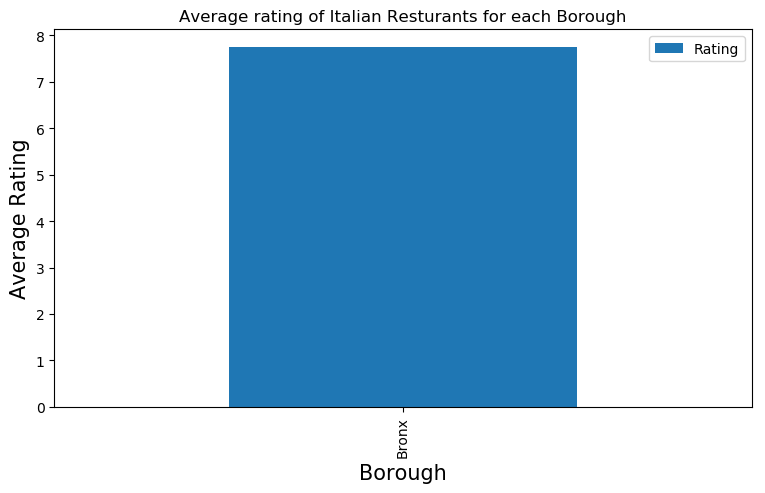

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [42]:
ny_neighborhood_stats

,Neighborhood,Average Rating


We will join this dataset to original new york data to get lonitude and latitude

In [43]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [44]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [45]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating


Now we will show this data on a map

In [46]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [47]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose

In [48]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [49]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Conclusion 
- Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for italian cuisine. 
- Manhattan have potential italian Resturant Market/ 
- Staten Island	ranks last in average rating of italian Resturants.
- Manhattan is the best place to stay if you prefer italian Cuisine.

### Limitations 
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare and the limited calls